In [1]:
%autosave 1

##Imports

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
import pandas as pd
pd.options.display.max_columns = None
from IPython.display import display

Autosaving every 1 seconds


In [2]:
## Data loading and data splitting functions

# read the csv file and return a dataframe
def data_read_df():
    d = {'f1': [10,20,30,40,50],
         'f2':[5,10,15,20,25],
         'f3': ['a','a','b','b','a'],
         'f4': ['x','x','x','y','y'],
         'f5': ['Alice','Bob','Claire','Alice','Bob'],
         'target': [1,1,1,0,0]}
    df = pd.DataFrame(d)
    return df

def data_split_train_and_test(df, test_size):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=0)

    y = df['target']
    for train_index, test_index in sss.split(df, y):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]

    y_train = X_train['target']
    y_test = X_test['target']
    X_train = X_train.drop(columns=['target'])
    X_test = X_test.drop(columns=['target'])
    
    return X_train, X_test, y_train, y_test

# Visualiztion functions


def visual_generate_bar_char_plot(df, feature_name):
    if len(df[feature_name].unique()) > 20:
        g = sns.FacetGrid(df, aspect=4)
    else:
        g = sns.FacetGrid(df, aspect=2)
    g.map(sns.countplot, feature_name, order=list(
        df[feature_name].value_counts().index))
    g.set_xticklabels(rotation=80)
    g.set_ylabels("count")


def visual_generate_category_target_prob_plot(df, feature_name):
    if len(df[feature_name].unique()) > 20:
        x = df[feature_name]
        g = sns.catplot(x=feature_name, y="target", data=df,
                        kind="bar", palette="muted", order=list(df[feature_name].value_counts().index), aspect=4)
    else:
        g = sns.catplot(x=feature_name, y="target", data=df,
                        kind="bar", palette="muted", order=list(df[feature_name].value_counts().index), aspect=1)
    g.set_xticklabels(rotation=80)
    g.set_ylabels("Prob. for target 1")
    plt.ylim(0, 1)


def visual_generate_dis_plot(df, feature_name):
    g = sns.FacetGrid(df, col='target', aspect=1)
    g = g.map(sns.distplot, feature_name)
    
## Training Functions

def train_model(ml_algo, df_train, y_train, params=None):   
    ''' 
    ml_algo options: 
        'LogisticRegression' / 'DecisionTree' / 'KNN' / 'RandomForest' / 'LDA' / 'MultinomialNB' / 'GaussianNB'
    '''
    if params is None:
        params = {}
    if ml_algo == 'LogisticRegression':
        if 'multi_class' not in params:
            params['multi_class'] = 'auto'
        if 'solver' not in params:
            params['solver'] = 'liblinear'
        classifier = LogisticRegression(**params)
    elif ml_algo == 'DecisionTree':
        classifier = DecisionTreeClassifier(**params)
    elif  ml_algo == 'KNN':
        classifier = KNeighborsClassifier(**params)
    elif ml_algo == 'RandomForest':
        if 'n_estimators' not in params:
            params['n_estimators'] = 100
        classifier = RandomForestClassifier(**params)
    elif ml_algo == 'LDA':
        classifier = LinearDiscriminantAnalysis(**params)
    elif ml_algo == 'MultinomialNB':
        classifier = MultinomialNB()
    elif ml_algo == 'GaussianNB':
        classifier = GaussianNB()
    else:
        raise(Exception("""The value of the ml-algo parameter should be one of the following:
                            LogisticRegression / DecisionTree / KNN / RandomForest / LDA / MultinomialNB / GaussianNB"""))
    
    classifier.fit(df_train, y_train)
    
    return classifier

## Evaluation functions

def eval_get_cm(classifier, X, y):
    cmtx = pd.DataFrame(
        confusion_matrix(classifier.predict(X), y),
        index=['pred:0', 'pred:1'],
        columns=['true:0', 'true:1']
    )
    return cmtx

def eval_get_score(classifier, X, y, metric):
    if metric == 'f1' or metric == 'auc':
        if (len(y_test.unique())) > 2 :
            raise(Exception('You cannot use the metric \'{}\' for multiclass classification tasks'.format(metric)))
    '''
    metric options:
        'precision' / 'recall' / 'accuracy' / 'auc' / 'f1'
    '''
    if metric == 'accuracy':
        return accuracy_score(y, classifier.predict(X), normalize=True)
    elif metric == 'f1':
        return f1_score(y, classifier.predict(X))
    elif metric == 'precision':
        from sklearn.metrics import precision_score
        return precision_score(y, classifier.predict(X))
    elif metric == 'recall':
        from sklearn.metrics import recall_score
        return recall_score(y, classifier.predict(X))
    elif metric == 'auc':
        predictions_proba = classifier.predict_proba(X)[:, 1]
        fpr, tpr, t = roc_curve(y, predictions_proba)
        roc_auc = auc(fpr, tpr)
    else:
        raise(Exception("""The value of the metric parameter sholud be one of the following:
                            precision / recall / accuracy / auc / f1"""))
    return roc_auc

def eval_plot_roc_curve(classifier, X, y):
    if (len(y_test.unique())) > 2:
        raise(Exception('You cannot use this function for multiclass classification tasks'))
    # predict probabilities
    y_pred_prob = classifier.predict_proba(X)

    fpr, tpr, t = roc_curve(y, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    fig1 = plt.figure(figsize=[12, 12])
    ax1 = fig1.add_subplot(111, aspect='equal')

    plt.plot(fpr, tpr, lw=2, alpha=0.3,
             label='AUC = ' + str(round(roc_auc, 2)))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

    plt.show()
    
def eval_get_predictions(classifier, X, y):
    predictions = classifier.predict(X)
    predictions_df = pd.DataFrame(
        {'example_index': list(X.index), 'Pred': list(predictions), 'True_value': list(y)}).set_index('example_index')
    return predictions_df

def get_predictions_proba(classifier, X, y):
    predictions = [round(pred,3) for pred in list(classdier.predict_proba(X)[:,1])]
    predictions_df = pd.DataFrame(
        {'example_index': list(X.index), 'pred': predictions, 'True_value': list(y)}).set_index('example_index')
    return predictions_df

## Feature engineering (FE) functions

def FE_encode_values_of_categorical_features(df, columns_to_encode):

    df_to_return = df.copy()
    le = LabelEncoder()
    for col in columns_to_encode:
        df_to_return[col] = le.fit_transform(df_to_return[col])
    return df_to_return

def FE_create_one_hot_encodeing(df, columns_to_encode):

    for x in columns_to_encode:
        df = pd.concat([df, pd.get_dummies(df[x], prefix=x)], axis=1)
        
    df = df.drop(columns = columns_to_encode)
    return df


def FE_divide_numeric_feature_to_ranges(df, column_to_divide_to_ranges, number_of_ranges):

    df_to_return = df.copy()
    df_to_return[column_to_divide_to_ranges] = pd.cut(df_to_return[column_to_divide_to_ranges], number_of_ranges)
    
    return df_to_return

## Feature Scaling Functions

def feature_scaling(X_train, X_test, columns_to_scale, scaler_method):

    X_train_to_return = X_train.copy()
    X_test_to_return = X_test.copy()
    
    if scaler_method == 'Normalizer':
        scaler = Normalizer()
    elif scaler_method == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_method == 'MinMaxScaler':
        scaler = MinMaxScaler()
    else:
        raise(Exception("""The value of the scaling_method parameter sholud be one of the following:
                            Normalize / StandardScaler / MinMaxScaler"""))
    
    for column in columns_to_scale:
        X_train_to_return[column] = X_train_to_return[column].astype(float)
        X_test_to_return[column] = X_test_to_return[column].astype(float)
    
    X_train_to_return[columns_to_scale] = scaler.fit_transform(X_train_to_return[columns_to_scale])
    X_test_to_return[columns_to_scale] = scaler.transform(X_test_to_return[columns_to_scale])
    
    return X_train_to_return, X_test_to_return

# Introduction

The API describes a set of functions that will assist you in the development of the predictive model. Using these functions will save you a lot of time!

The functions are divided into several categories:
<font color='blue'>
* Data Loading and Data Splitting Functions
* Visualization Functions
* Feature Engineering (FE) Functions
* Feature Scaling Functions
* Training Functions
* Evaluation Functions
</font>

Each section in this Notebook reviews a separate function set.

We will begin with the Data Loading and Data Splitting functions.

# Data Loading and Data Splitting Functions

There are two functions in this set:
<font color='blue'>
 * data_read_df() : df
 * data_split_train_and_test(df, test_size) : X_train, y_train, X_test, y_test
</font>

Let us begin with `data_read_df()`.

The purpose of this function is to import the task's dataset to a DataFrame object.

**Exercise**: Set df to the `returned value from data_read_df()` in the cell below and run the cells bellow.

In [3]:
### START CODE HERE ### (≈ 1 line of code)
df = data_read_df()
### END CODE HERE ###

In [4]:
df

,f1,f2,f3,f4,f5,target
0,10,5,a,x,Alice,1
1,20,10,a,x,Bob,1
2,30,15,b,x,Claire,1
3,40,20,b,y,Alice,0
4,50,25,a,y,Bob,0


**Expected output**:
<img src="images/data_read_df.png">

We will now try to use `data_split_train_and_test(df, test_size) : X_train, X_test, y_train, y_test`.
This function receives a DataFrame and test_size and returns 2 DataFrames (X_train and X_test) and 2 Series (y_train, y_test) 

**Exercise**: Set X_train, X_test, y_train and y_test to the returned value from `data_split_train_and_test(df, test_size)` while `df is df from the previous exercise` and `test_size is 0.3`. Then, run the cells bellow to display the output.

In [5]:
### START CODE HERE ### (≈ 1 line of code)
X_train, X_test, y_train, y_test = data_split_train_and_test(df, 0.3)
### END CODE HERE ###

In [6]:
display('X_train =') 
display(X_train)
display('X_test =') 
display(X_test)
display('y_train =') 
display(y_train)
display('y_test =') 
display(y_test)

'X_train ='

,f1,f2,f3,f4,f5
2,30,15,b,x,Claire
4,50,25,a,y,Bob
1,20,10,a,x,Bob


'X_test ='

,f1,f2,f3,f4,f5
0,10,5,a,x,Alice
3,40,20,b,y,Alice


'y_train ='

2    1
4    0
1    1
Name: target, dtype: int64

'y_test ='

0    1
3    0
Name: target, dtype: int64

<br><br><br><br><br><br>
**Expected output**:
<img src="images/data_split_train_and_test.png">

# Visualization Functions

This set of functions includes three functions:
<font color='blue'>
 * visual_generate_bar_chart_plot(df, feature_name) : plot
 * visual_generate_category_target_prob_plot(df, feature_name) : plot
 * visual_generate_dis_plot(df, feature_name) : plot
</font>

**Exercise**: Generate 3 plots for the DataFrame `df`. `bar chart` and `target prob plot` for the feature `f3` and `distribution (dis)` for the feature `f1`. 

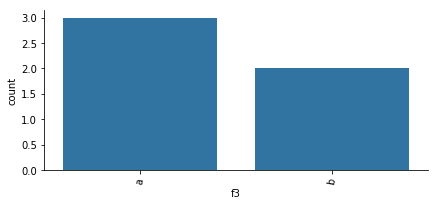

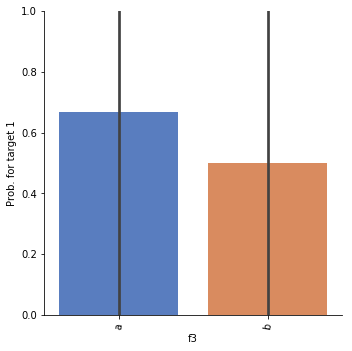

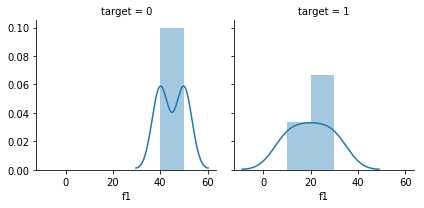

In [7]:
### START CODE HERE ### (≈ 3 lines of code)
visual_generate_bar_char_plot(df, 'f3')
visual_generate_category_target_prob_plot(df, 'f3')
visual_generate_dis_plot(df, 'f1')
### END CODE HERE ###

<br><br><br><br>
**Expected output**:
<img src="images/visualization.png">

## Feature engineering (FE) functions

There are four functions in this set:
<font color='blue'>
 * FE_encode_values_of_categorical_features(df, columns_to_encode) : df
 * FE_create_one_hot_encodeing(df, columns_to_encode) : df
 * FE_divide_numeric_feature_to_ranges(df, column_to_divide_to_ranges, number_of_ranges) : df
 * FE_feature_scaling(X_train, X_test, features_to_scale, scaler_method) : df
</font>

We shall begin with `FE_encode_values_of_categorical_features`.
The purpose of this function is to encode (replace strings with numbers) the values of a categorical feature.

The function receives `DataFrame` and `columns to encode (list of features' names)` as input and returns a `new DataFrame`

**Exercise**: Encode the values of `f3`, `f4` of `df` and assign the resulting DataFrame to `df_encoded_values`, then run the cells below to see the output.

In [8]:
### START CODE HERE ### (≈ 2 lines of code)
columns_to_encode = ['f3', 'f4']
df_encoded_values = FE_encode_values_of_categorical_features(df, columns_to_encode)
### END CODE HERE ###

In [9]:
df_encoded_values

,f1,f2,f3,f4,f5,target
0,10,5,0,0,Alice,1
1,20,10,0,0,Bob,1
2,30,15,1,0,Claire,1
3,40,20,1,1,Alice,0
4,50,25,0,1,Bob,0


**Expected output**:
<img src="images/FE_encode_values_of_catagorial_features.png">

We will now encode the values of `f5` using `one-hot-encoding`.

**Exercise**: Encode the values of `f5` in `df_encoded_values` using the `one_hot_encoding` method and assign the resulting DataFrame to `df_encoded_values2`.

In [10]:
### START CODE HERE ### (≈ 2 lines of code)
columns_to_encode = ['f5']
df_encoded_values2 = FE_create_one_hot_encodeing(df_encoded_values, columns_to_encode)
### END CODE HERE ###

In [11]:
df_encoded_values2

,f1,f2,f3,f4,target,f5_Alice,f5_Bob,f5_Claire
0,10,5,0,0,1,1,0,0
1,20,10,0,0,1,0,1,0
2,30,15,1,0,1,0,0,1
3,40,20,1,1,0,1,0,0
4,50,25,0,1,0,0,1,0


**Expected output**:
<img src="images/FE_create_one_hot_encodeing.png">

You will now try to use the `FE_divide_numeric_feature_to_ranges` function. This function divides the values of continuous features into ranges.

**Exercise**: Divide the values of `f1` of `df_encoded_values2` into `three` ranges and assign the resulting DataFrame to `df_encoded_values_and_ranges_values`

In [12]:
### START CODE HERE ### (≈ 1 line of code)
df_encoded_values_and_ranges_values = FE_divide_numeric_feature_to_ranges(df_encoded_values2, 'f1', 3)
### END CODE HERE ###

In [13]:
df_encoded_values_and_ranges_values

,f1,f2,f3,f4,target,f5_Alice,f5_Bob,f5_Claire
0,"(9.96, 23.333]",5,0,0,1,1,0,0
1,"(9.96, 23.333]",10,0,0,1,0,1,0
2,"(23.333, 36.667]",15,1,0,1,0,0,1
3,"(36.667, 50.0]",20,1,1,0,1,0,0
4,"(36.667, 50.0]",25,0,1,0,0,1,0


**Expected output**:
<img src="images/FE_divide_continious_feature_to_ranges.png">

Before we continue to the next section, we would like you to encode the values of `f1` in `df_encoded_values_and_ranges_values` and then split the resulting DataFrame into train and test.

**Exercise**: Encode the values of `f1` in `df_encoded_values_and_ranges_values` using `FE_encode_values_of_categorical_features` and assign the returned DataFrame to `df_encoded_values_and_ranges_values2`, then run the cell to explore the output.

In [14]:
### START CODE HERE ### (≈ 2 line of code)
columns_to_encode = ['f1']
df_encoded_values_and_ranges_values2 = FE_encode_values_of_categorical_features(df_encoded_values_and_ranges_values, columns_to_encode)
### END CODE HERE ###

In [15]:
df_encoded_values_and_ranges_values2

,f1,f2,f3,f4,target,f5_Alice,f5_Bob,f5_Claire
0,0,5,0,0,1,1,0,0
1,0,10,0,0,1,0,1,0
2,1,15,1,0,1,0,0,1
3,2,20,1,1,0,1,0,0
4,2,25,0,1,0,0,1,0


**Expected output**:
<img src="images/FE_divide_continious_feature_to_ranges2.png">

**Exercise**: Split `df_encoded_values_and_ranges_values2` into train and test (test size = 0.3), assign the returned values to `X_train`, `X_test`, `y_train`, `y_test`, and run the cells below.

Use the following function:
`data_split_train_and_test(df, test_size) : X_train, X_test, y_train, y_test`

In [16]:
### START CODE HERE ### (≈ 1 line of code)
X_train, X_test, y_train, y_test = data_split_train_and_test(df_encoded_values_and_ranges_values2, 0.3)
### END CODE HERE ###

In [17]:
display('X_train =') 
display(X_train)
display('X_test =') 
display(X_test)
display('y_train =') 
display(y_train)
display('y_test =') 
display(y_test)

'X_train ='

,f1,f2,f3,f4,f5_Alice,f5_Bob,f5_Claire
2,1,15,1,0,0,0,1
4,2,25,0,1,0,1,0
1,0,10,0,0,0,1,0


'X_test ='

,f1,f2,f3,f4,f5_Alice,f5_Bob,f5_Claire
0,0,5,0,0,1,0,0
3,2,20,1,1,1,0,0


'y_train ='

2    1
4    0
1    1
Name: target, dtype: int64

'y_test ='

0    1
3    0
Name: target, dtype: int64

<br><br><br><br><br><br>
**Expected output**:
<img src="images/split_train_and_test2.png">

# Feature Scaling Functions

This section only includes a single function which scales the values of numeric variables:

`feature_scaling(X_train, X_test, columns_to_scale, scaler_method): X_train, X_test`

The function's input is `DataFrame`, `columns' names for scaling their values` and `scaling method` (str). The returned values are new X_train and X_test.

The `scaling method` should be one of the following:
<font color='blue'>
 * 'Normalizer'
 * 'StandardScaler'
 * 'MinMaxScaler'
</font>
For more information about these methods, you can google the name of the method and sklearn keyword (e.g. sklearn StandardScaler)

**Exercise**: Scale the values of `f2` in `X_train` and `X_test` using the `StandardScaler` scaling method and assign the returned values to `X_train` and `X_test` (overwrite their values).

In [18]:
### START CODE HERE ### (≈ 1 line of code)
columns_to_scale = ['f2']
X_train, X_test = feature_scaling(X_train, X_test, columns_to_scale, 'StandardScaler')
### END CODE HERE ###

In [19]:
display('X_train =')
display(X_train)
display('X_test =')
display(X_test)

'X_train ='

,f1,f2,f3,f4,f5_Alice,f5_Bob,f5_Claire
2,1,-0.267261,1,0,0,0,1
4,2,1.336306,0,1,0,1,0
1,0,-1.069045,0,0,0,1,0


'X_test ='

,f1,f2,f3,f4,f5_Alice,f5_Bob,f5_Claire
0,0,-1.870829,0,0,1,0,0
3,2,0.534522,1,1,1,0,0


<br><br>
**Expected output**:
<img src="images/scaling.png">

# Training functions

This section only includes a single function:

`train_model(ml_algo, df_train, y_train, params={}): classifier`

The function receives `name of a machine learning algorithm`, `parameters for the algorithm` (if not given, it will use the default Sklearn parameters), the `train’s examples` and `targets` as inputs, and returns a `trained classifier` (after fitting it to train).

The `ml-algo` parameter sholud be one of the following:
<font color='blue'>
 * 'LogisticRegression’
 * 'DecisionTree'
 * 'KNN'
 * 'RandomForest'
 * 'LDA'
 * 'NaiveBayes'
</font>

Example of `params` parameter:

To use `l2` for `penalty` and `C=1` to train `LogisticRegression`, you can send the `params` varaiable to the function as follows:

params = {
    'penalty' = 'l2'
    'C' = 1
}

**For more information about the optional parameters, you can google the name of the ML algorithm and the sklearn keyword (e.g. sklearn LogisticRegression)**

**Exercise**: Train a LogisticRegression classifier using the `default parameters` and `X_train` and `y_train` for fitting. Assign the returned value to a variable called `classifier`.

In [20]:
### START CODE HERE ### (≈ 1 line of code)
classifier = train_model('LogisticRegression', X_train, y_train)
### END CODE HERE ###

# Evaluation

The last set of functions is `Evaluation`. The purpose of these functions is to evaluate your model on a test set.

It includes five functions, but we will only practice two functions because the all five functions work on very similar principles.


Here is the entire list of `evaluation` functions:

<font color='blue'>
    
 * eval_get_score(classifier, X, y, metric) : score (Float)
    
 * eval_get_cm(classifier, X, y) : cm (DataFrame)
 
 * eval_get_predictions(classifier, X, y) : predictions (DataFrame)
 
 * eval_get_predictions_proba(classifier, X, y) : predictions (DataFrame)
 
 * eval_plot_roc_curve(classifier, X, y): plot a grpah
</font>

Let us begin with eval_get_score(classifier, X, y, metric).

This function recieves `trained classifier`, `X (examples to predict)`, `y (target values of X)` and `metric` as inputs.

metric should be one of the following:
<font color='blue'>
    
 * 'precision'
    
 * 'recall'

 * 'accuracy'
 
 * 'auc'

 * 'f1'
 
</font>

**Exercise**: Calculate the accuracy for `X_test` and `y_test` when using the `classifier` you trained in the last section.

In [21]:
### START CODE HERE ### (≈ 1 line of code)
accuracy = eval_get_score(classifier, X_test, y_test, 'accuracy')
### END CODE HERE ###

In [22]:
print('Accuracy: {}'.format(accuracy))

Accuracy: 1.0


**Expected output:**

Accuracy: 1.0

**Exercise**: print the predictions for `X_test` when using the `classifier` you trained in the last section.

In [23]:
### START CODE HERE ### (≈ 1 line of code)
predictions_df = eval_get_predictions(classifier, X_test, y_test)
### END CODE HERE ###

In [24]:
predictions_df

,Pred,True_value
example_index,,
0,1,1
3,0,0


**Expected output**:
<img src="images/eval_get_predictions.png">

<center><a href="http://localhost:8889/notebooks/Dropbox%20(BGU)/Expert%20vs%20Novices%20Experiment/Adult%20Experiment.ipynb">Link to start the experiment</a></center>